In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [20]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_44268\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [21]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - prazna luna

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med prazno luno, razlikuje od ritmičnosti ostalih nesreč.

In [22]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'New Moon')

accidents_new_moon = accidents_moon[moon_mask]
# display(accidents_new_moon)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_new_moon['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNewMoon",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

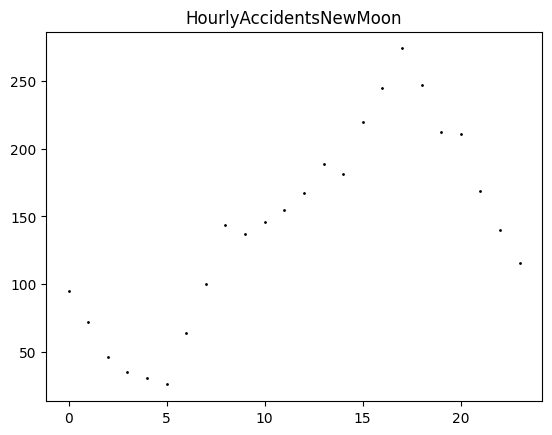

In [23]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNewMoon"])

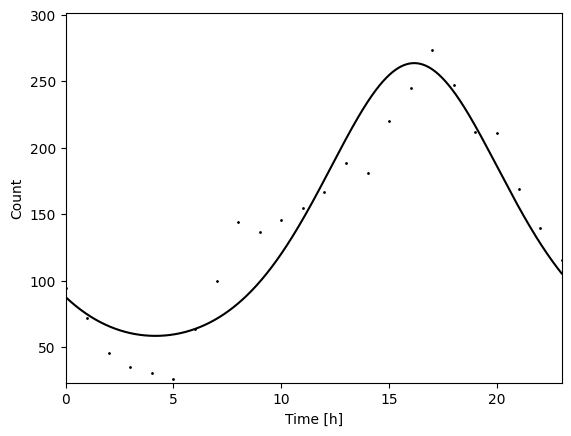

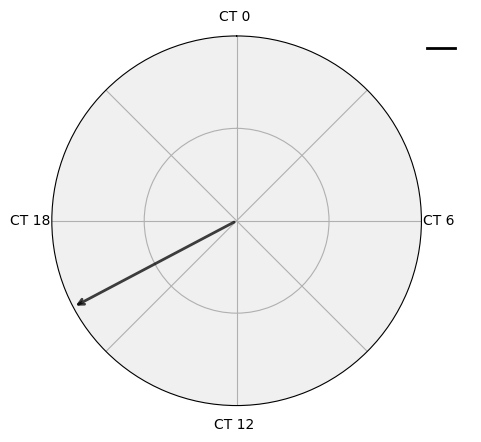

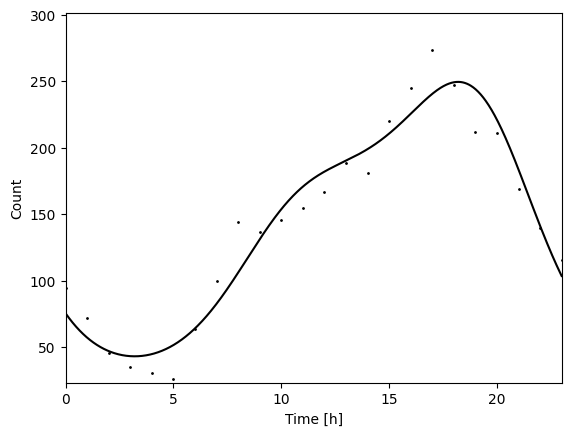

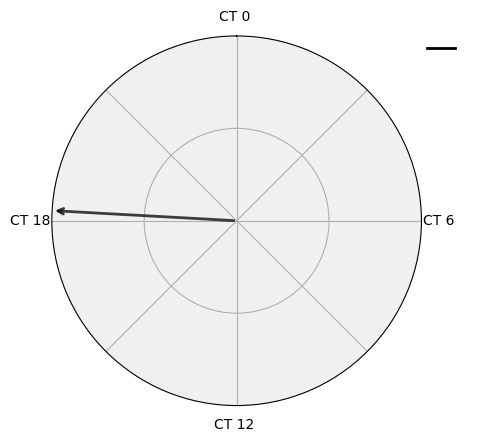

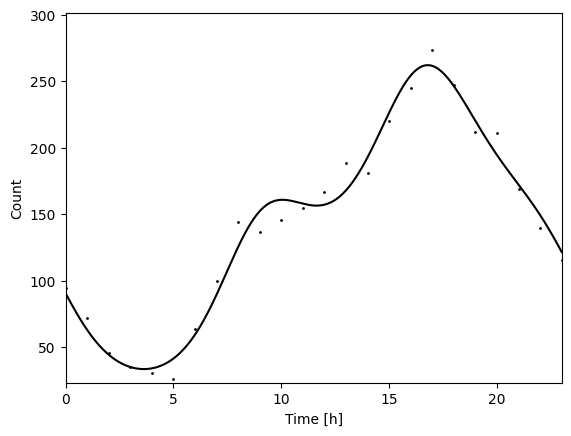

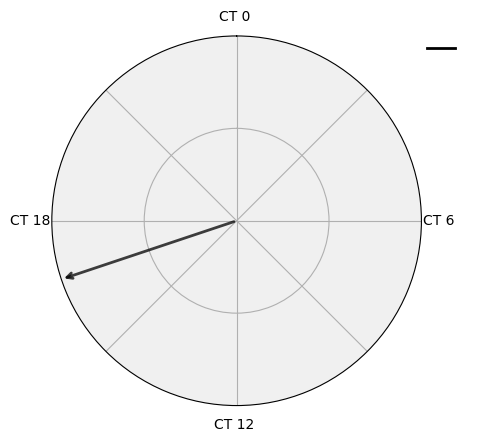

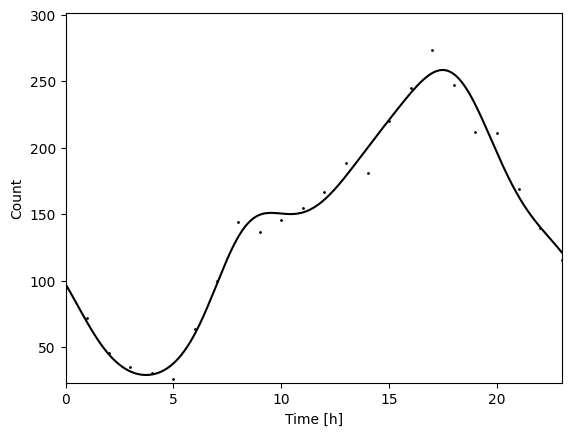

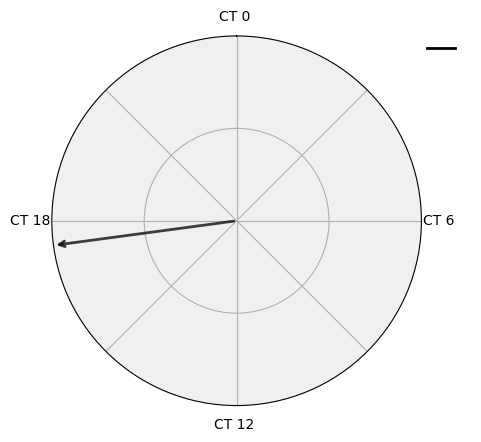

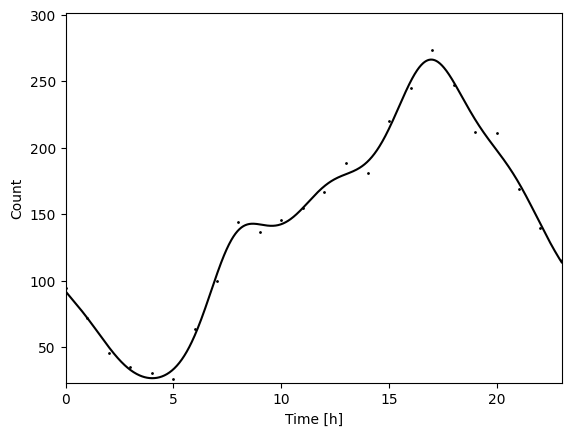

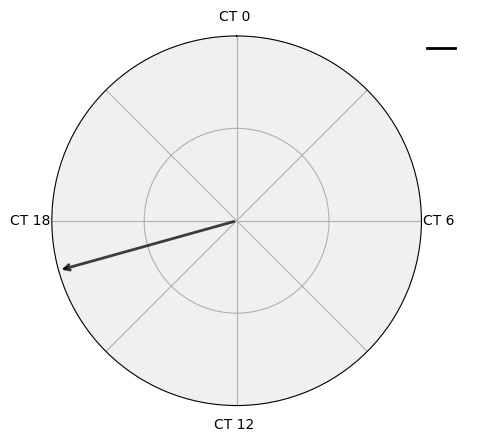

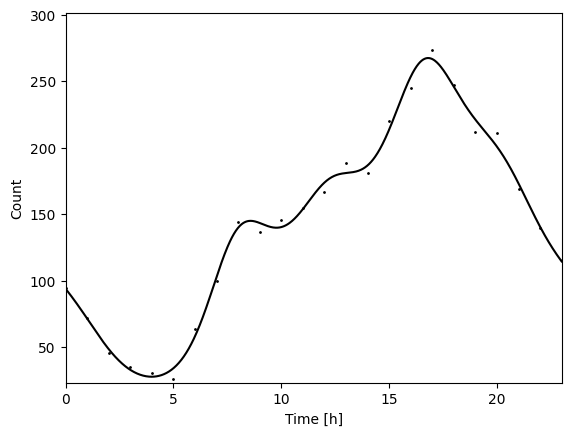

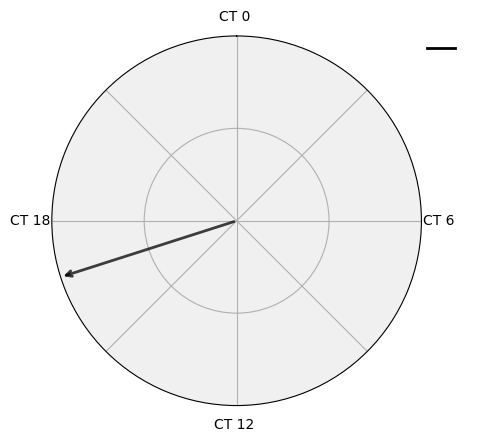

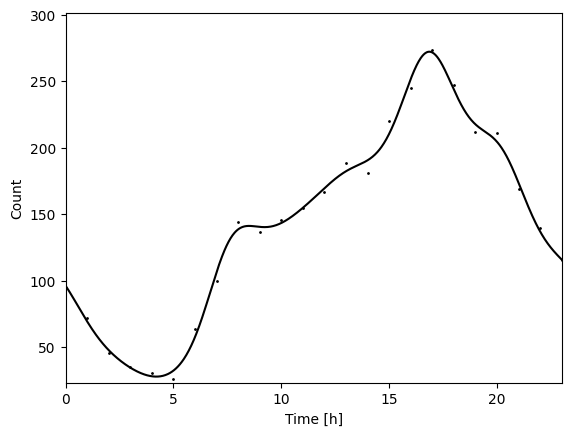

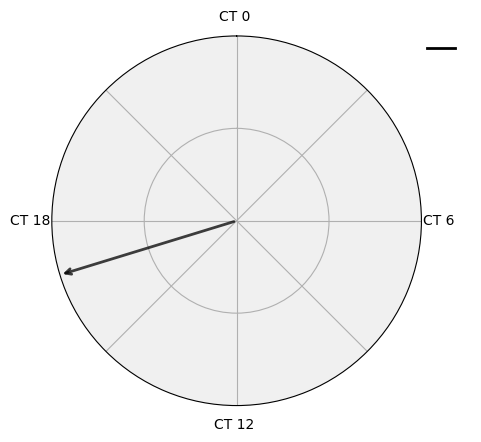

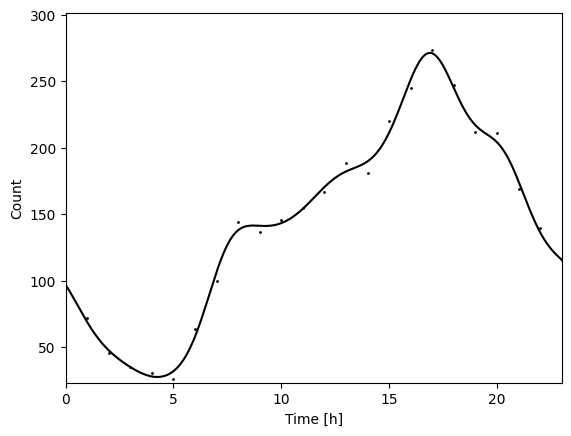

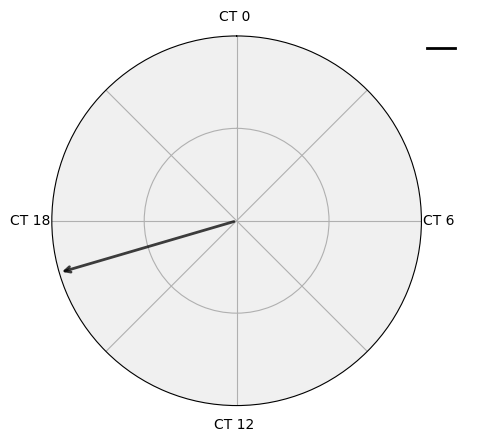

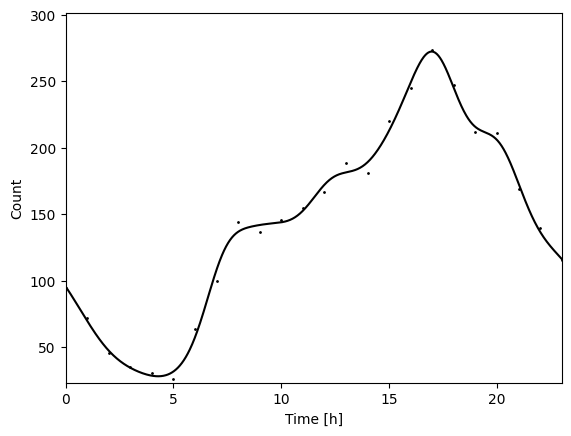

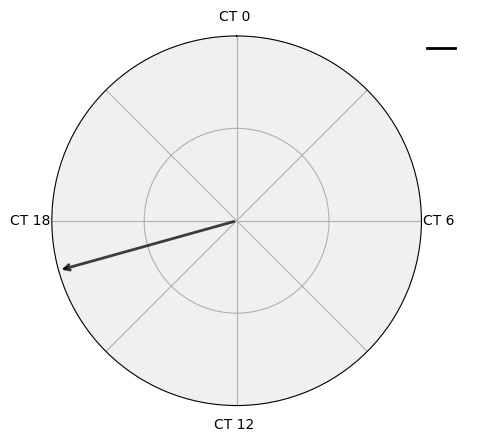

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


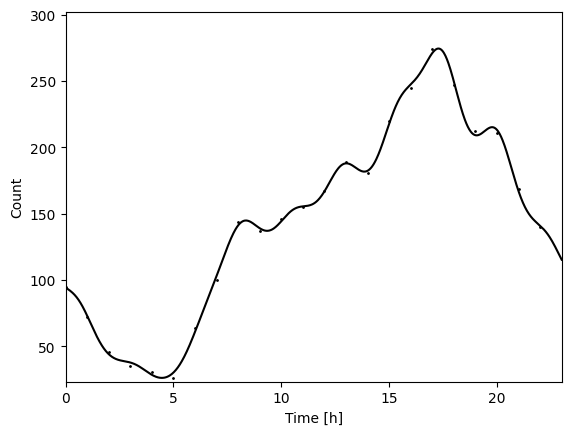

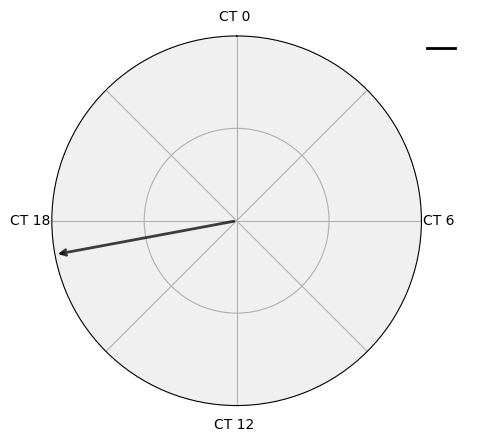

In [24]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNewMoon', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [25]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNewMoon,24.0,1.0,1.675452e-11,1.675452e-11,15820.032028,-113.975897,0.178778,102.580391,2.056658,161.218927,[16.144144144144143],[263.79710844628084],[4.18018018018018],[58.63891683553621]
1,HourlyAccidentsNewMoon,24.0,2.0,1.884225e-14,2.093583e-14,7243.031908,-103.596751,0.253563,103.203756,1.515763,146.477347,[18.21021021021021],[249.68093934121543],[3.219219219219219],[43.274683459103265]
2,HourlyAccidentsNewMoon,24.0,3.0,2.181788e-18,2.727235e-18,2721.255491,-91.041304,0.344027,114.300732,1.893132,147.960608,"[10.042042042042041, 16.76876876876877]","[161.00623816749982, 262.2549926790322]",[3.6036036036036037],[33.662012692057615]
3,HourlyAccidentsNewMoon,24.0,4.0,1.884526e-19,2.692180e-19,2102.190114,-85.479483,0.384101,114.703424,1.704448,143.922282,"[9.513513513513514, 17.48948948948949]","[151.14741604564335, 258.62570525880216]",[3.7477477477477477],[29.219941109345257]
4,HourlyAccidentsNewMoon,24.0,5.0,5.356363e-22,2.678181e-21,801.818638,-76.388344,0.449605,119.830884,1.842816,146.631416,[16.96096096096096],[266.46229955500206],"[4.036036036036036, 9.561561561561561]","[26.80247486185672, 141.41300277994938]"
5,HourlyAccidentsNewMoon,24.0,6.0,2.586014e-21,7.082783e-21,738.233998,-75.339759,0.457160,119.856618,1.880553,147.766539,[16.816816816816818],[267.6231575014986],"[3.987987987987988, 9.753753753753754]","[27.909921160697014, 139.98929795308612]"
6,HourlyAccidentsNewMoon,24.0,7.0,2.833113e-21,7.082783e-21,590.218214,-72.826370,0.475270,122.188242,1.867974,150.190632,[16.864864864864863],[272.3788735546568],"[4.18018018018018, 9.225225225225225]","[28.00559155887035, 140.43830992615676]"
7,HourlyAccidentsNewMoon,24.0,8.0,2.369206e-20,4.738412e-20,584.285409,-72.674661,0.476363,121.875970,1.855395,149.593419,[16.912912912912912],[271.45608301792527],"[4.228228228228228, 9.225225225225225]","[27.719843823263993, 141.32195202890568]"
8,HourlyAccidentsNewMoon,24.0,9.0,1.254670e-19,2.091117e-19,534.875276,-72.150824,0.480137,122.115464,1.842816,150.369109,[16.96096096096096],[272.48457304243306],[4.276276276276276],[28.253763173028563]
9,HourlyAccidentsNewMoon,24.0,10.0,9.857189e-24,9.857189e-23,119.422268,-59.094417,0.574212,124.112071,1.754763,150.397075,"[13.02102102102102, 17.2972972972973, 19.79579...","[187.9982472189574, 274.5091460515534, 215.232...","[4.468468468468468, 9.32132132132132]","[26.28500361958564, 137.13764101284542]"


### Katero je najboljše število komponent

In [26]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNewMoon,24.0,5.0,5.356363e-22,2.678181e-21,801.818638,-76.388344,0.449605,119.830884,1.842816,146.631416,[16.96096096096096],[266.46229955500206],"[4.036036036036036, 9.561561561561561]","[26.80247486185672, 141.41300277994938]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


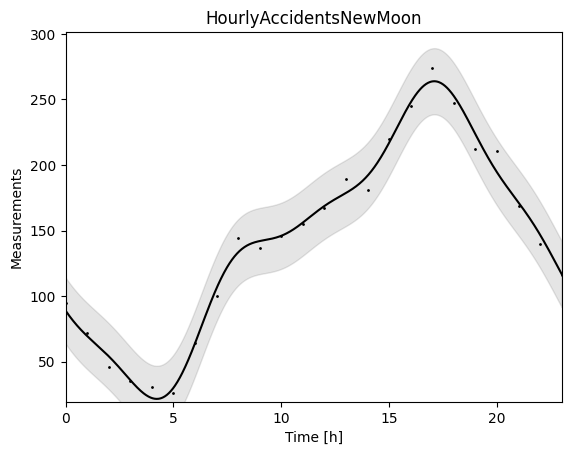

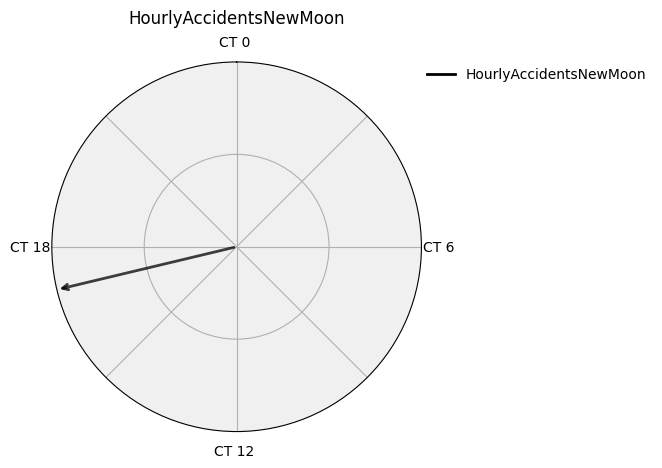

In [27]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [28]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsNewMoon",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [29]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

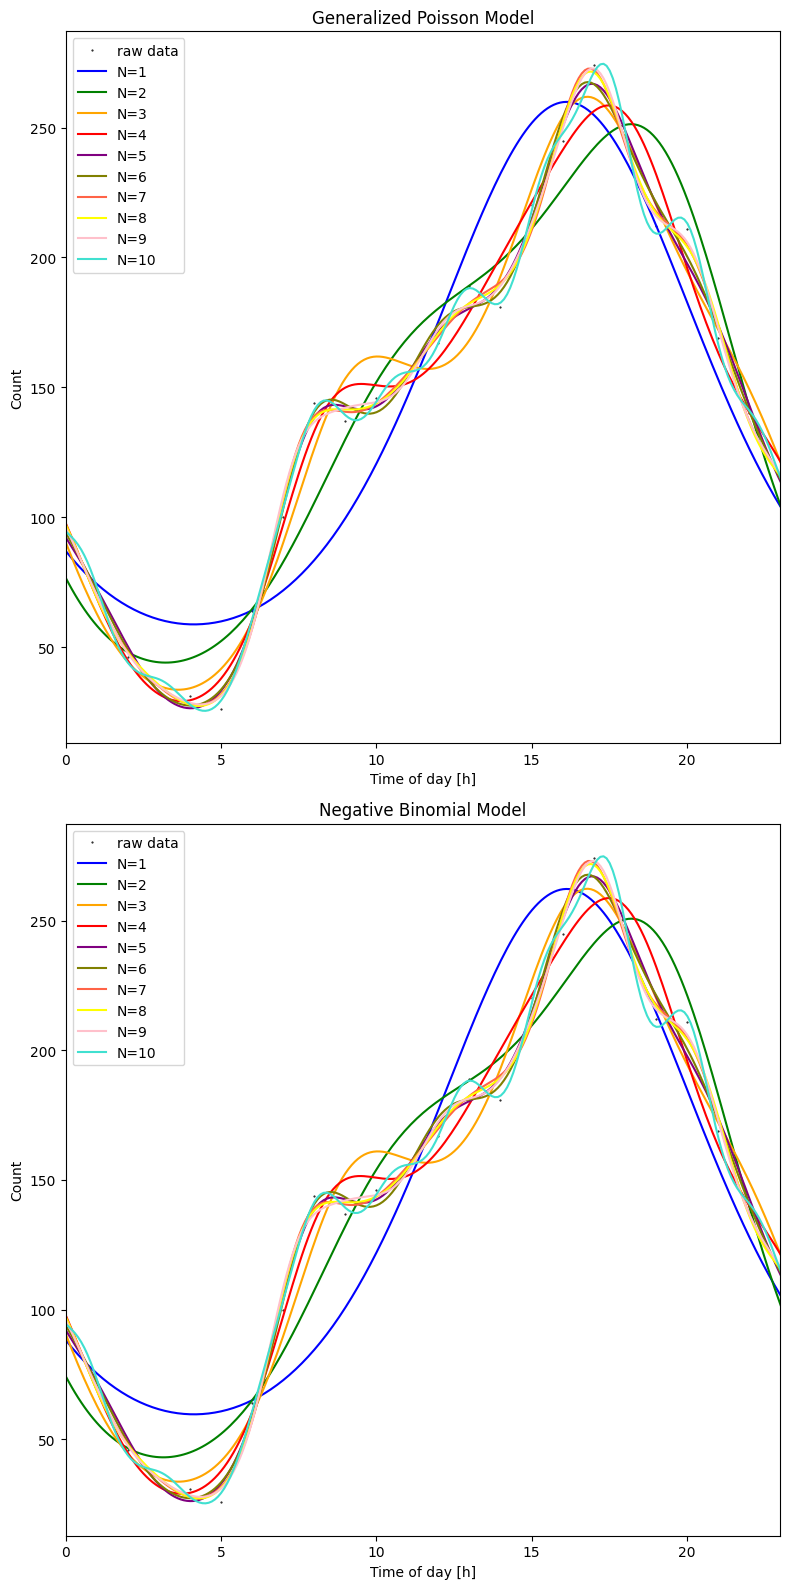

In [30]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [31]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,100.58,159.30,[16.12],[259.89],1.751344e-11,15608.402445,236.040395,240.752610,-114.020197,"[-4.266010241917172, -4.008706800317995, -4.14...",141.213290,"[87.02436400490565, 74.31496501105589, 65.6979...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[87.02436400490565, 85.55132210348167, 84.1244..."
1,gen_poisson,2,103.65,147.66,[18.22],[251.31],2.941315e-14,7214.199510,220.109658,227.177981,-104.054829,"[-4.554789753416571, -4.1799260217355325, -3.2...",142.872319,"[76.70478999806771, 58.28853368243, 48.0351976...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[76.70478999806771, 74.43589683103082, 72.2664..."
2,gen_poisson,3,114.14,147.71,[16.82],[261.85],2.452012e-18,2730.658516,198.326137,207.750568,-91.163069,"[-3.2329299877989257, -3.718335710182842, -2.7...",142.639244,"[90.436408836175, 62.892454026323406, 44.26636...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[90.436408836175, 87.3908504093183, 84.3919922..."
3,gen_poisson,4,114.68,143.84,[17.52],[258.52],3.066500e-19,2108.171633,191.989865,203.770404,-85.994933,"[-3.138417010303172, -3.029737507321755, -2.73...",142.583333,"[97.76807578746649, 68.87365879722833, 44.8584...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[97.76807578746649, 94.97607789666947, 92.1320..."
4,gen_poisson,5,120.20,146.63,[16.92],[266.84],4.418061e-20,796.058898,186.220526,200.357172,-81.110263,"[-3.13106444406732, -2.9503013569904226, -2.96...",142.583333,"[92.30732371704708, 72.48400997036451, 50.2960...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[92.30732371704708, 90.38263810058835, 88.4662..."
5,gen_poisson,6,120.02,147.49,[16.82],[267.52],3.919659e-19,746.125355,189.606484,206.099238,-80.803242,"[-3.090222312147219, -2.9475533222010597, -2.8...",142.583333,"[94.08495338639595, 71.78232175359216, 48.9825...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[94.08495338639595, 91.99699533453584, 89.8802..."
6,gen_poisson,7,122.53,150.15,[16.82],[272.68],1.874908e-18,590.354062,192.000644,210.849505,-80.000322,"[-3.1019966742649814, -3.001081007824695, -2.7...",142.583333,"[96.4873092399141, 69.45012160950398, 48.14953...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[96.4873092399141, 93.93712857569926, 91.30245..."
7,gen_poisson,8,122.13,149.44,[16.92],[271.57],1.531604e-17,586.158234,195.895622,217.100591,-79.947811,"[-3.1226527301951563, -3.0250504722357903, -2....",142.583333,"[97.2972875595212, 68.95988328811914, 47.94296...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[97.2972875595212, 94.67741868839266, 91.94103..."
8,gen_poisson,9,122.40,150.33,[17.02],[272.73],1.019123e-16,539.720623,199.620596,223.181673,-79.810298,"[-3.094801500620065, -2.9793732915857163, -2.7...",142.583333,"[96.08403056466325, 70.00526293875063, 47.6411...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[96.08403056466325, 93.63509442336084, 91.1247..."
9,gen_poisson,10,124.56,150.00,"[17.32, 19.82]","[274.55, 215.33]",1.233971e-16,123.610651,199.614837,225.532021,-77.807419,"[-3.0865612194576926, -2.9630786538029668, -2....",142.583333,"[94.55820873539156, 73.259073595273, 43.994164...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[94.55820873539156, 93.44673885892986, 92.2694..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [32]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 5


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [33]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 5
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

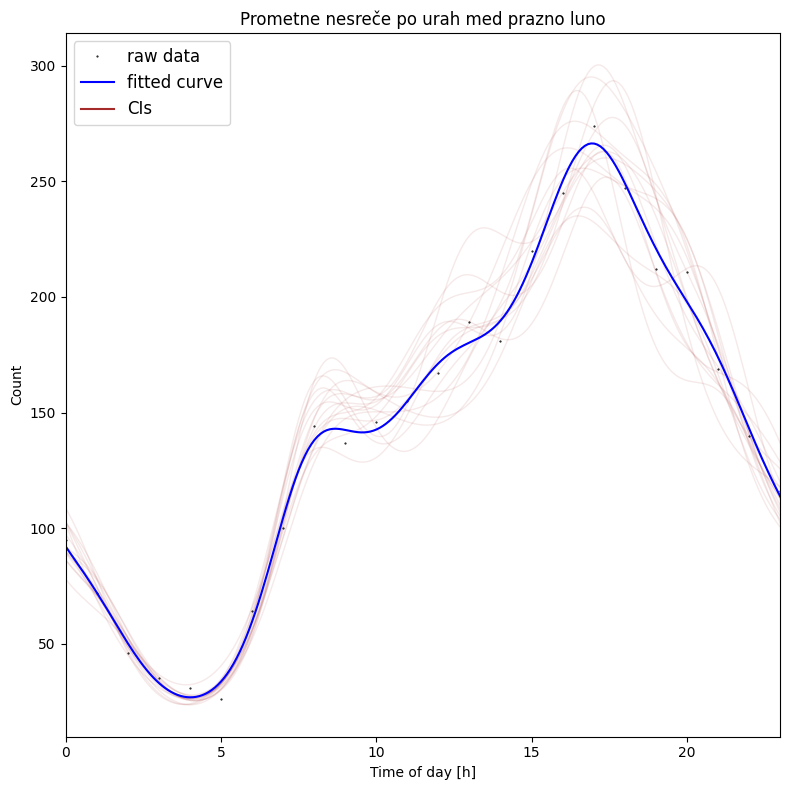

Intervali zaupanja:


,0,1
0,4.746084,4.817332
1,-0.777007,-0.674379
2,-0.508736,-0.416555
3,-0.357200,-0.265167
4,-0.041874,0.086863
5,-0.026113,0.077116
6,0.158069,0.260701
7,0.047269,0.139107
8,-0.022914,0.091269
9,-0.032151,0.066628


In [36]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah med prazno luno', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [35]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,5
amplitude,120.2
mesor,146.63
peaks,[16.92]
heights,[266.84]
amplitude_CIs,"[109.39, 130.31]"
mesor_CIs,"[138.61, 156.04]"
peaks_CIs,"[16.45, 17.18]"
heights_CIs,"[248.37, 285.99]"
